# Set up farm run

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

import yaml as yaml
Loader=yaml.safe_load

# Make all plots inline 
%matplotlib inline

In [2]:
verbose=False

In [3]:
if verbose:
    for x in amrwindfedirs:
        if os.path.exists(x+"/turbines/summitlayoutturbs.yaml"):
            with open(x+"/turbines/summitlayoutturbs.yaml") as f: print(f.read())

In [4]:
def updateturbdf(df, csvfile, col, numhead=1, splitdelim=None):
    csvdat      = [line.strip().split(splitdelim) for line in open(csvfile, 'r')][numhead:]
    for row in csvdat:
        turbname = row[0]
        val      = row[1]
        df.loc[df['# name'] == turbname, col]  = val
    return df

def updateturbs(df, changeKPturb='', numhead=1, splitdelim=None):
    KPcsvfile = 'KP_turbine_yaw.txt'
    df        = updateturbdf(df, KPcsvfile, ' yaw')
    # Change the KP turb type if necessary
    if len(changeKPturb)>0:
        csvdat    = [line.strip().split(splitdelim) for line in open(KPcsvfile, 'r')][numhead:]
        for row in csvdat:
            turbname = row[0]
            df.loc[df['# name'] == turbname, ' type']  = changeKPturb
    return df

def removeturbines(runcase):
    physics = runcase.getAMRWindInput('incflo.physics')
    if 'Actuator' in physics:
        physics.remove('Actuator')
        runcase.setAMRWindInput('physics', physics)
        print('SET incflo.physics: '+repr(runcase.getAMRWindInput('incflo.physics')))
    runcase.setAMRWindInput('ActuatorForcing', False)    
    runcase.listboxpopupwindict['listboxactuator'].deleteall()
    return

In [5]:
# Start the AMR-Wind case
#rundir = '/ccs/home/lcheung/scratch.cfd162/AWAKEN/UnstableABL1_farmrun1'
case = amrwind.MyApp.init_nogui()

In [6]:
precursordir  = '/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_precursor2'

precursorsetup= precursordir+'/UnstableABL_precursor2.inp'

cwd              = os.getcwd()
farmrundir       = '/ccs/proj/cfd162/lcheung/AWAKEN_summit_setup/UnstableABL_farmrun1/template_run2_radar'
#'/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/test/testOFfarmrun'
outputfile       = 'UnstableABL_farmrun2_wturbs_radar.inp'
noturboutputfile = 'UnstableABL_farmrun2_noturbs_radar.inp' 

# Make a copy of the precursor input for posterity
try:
    shutil.copy2(precursorsetup, './')
except:
    pass

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict([('amr.blocking_factor', '32'), ('amr.max_grid_size', '64')])

In [7]:
tstart = 16125
tstop  = 16125+900
textra = 1500

In [8]:
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop+textra)
case.setAMRWindInput('time.fixed_dt', 0.1)
case.setAMRWindInput('time.max_step',  -1)

In [9]:
# Set the restart point
chkdir = precursordir+'/chk64500/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [10]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics59500.nc'
tavg        =  [tstart, tstop]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['ylo'] #['ylo', 'xhi']
bndryfiles  = precursordir+'/bndry_fdata'

In [11]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/gpfs/alpine/cfd162/scratch/lcheung/AWAKEN/UnstableABL1_precursor2/bndry_fdata'
SET ABL_bndry_planes = ['ylo']
SET is_periodicy = False
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.17
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET BodyForce = True
SET BodyForce_magnitude = [-0.0008322974243443176, 0.00012478819121495535, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'


## Add turbines

In [12]:
#gitrepo            = '/autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/precursor/UnstableABL1/'
summitcsv          = 'UnstableABL_farmrun_turbines2.csv'

# Use this to load the csv directly
#case.loadTurbineCSVFile(summitcsv)

In [13]:
# Load the data from the database of all turbines
allturbsdf = pd.read_csv(summitcsv, low_memory=False)
allturbsdf = updateturbs(allturbsdf)
turbinescsvstring = allturbsdf.to_csv(index=False)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsvstring)

In [14]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

# # Print out existing list of turbines, just to confirm that the turbines got made
#print(case.listboxpopupwindict['listboxactuator'].getitemlist())

## Add refinement regions

In [15]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
#0,     30000,    30000,      40000,  100,  1000,      center:farm units:meter
#1,  10000,    7500,    21000,  100,  250, center:specified units:meter centerx:653000 centery:4050000 centerz:100 name:TR
#1,   7500,    6500,    12500,  100,  250, center:specified units:meter centerx:640000 centery:4030000 centerz:100 name:KP
#1,  11000,    9000,    12500,  100,  250, center:specified units:meter centerx:630000 centery:4018000 centerz:100 name:AF
#1,   4000,    3000,     9000,  100,  250, center:specified units:meter centerx:618000 centery:4035000 centerz:100 name:BR
#1,  10000,    5000,    14000,  100,  250, center:specified units:meter centerx:618000 centery:4050000 centerz:100 name:CV
2,     0.6,    0.6,     0.6,    0.525, 0.525, orientation:nacdir
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', False)

In [16]:
case.refine_createAllZones()

In [17]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0   3355443200             20.0 x 20.0 x 20.0
       1   5280000000             10.0 x 10.0 x 10.0
       2   5966800000                5.0 x 5.0 x 5.0
       3     67810645                2.5 x 2.5 x 2.5
  TOTAL:  14670053845


In [18]:
#print(case.listboxpopupwindict['listboxtagging'].getitemlist())

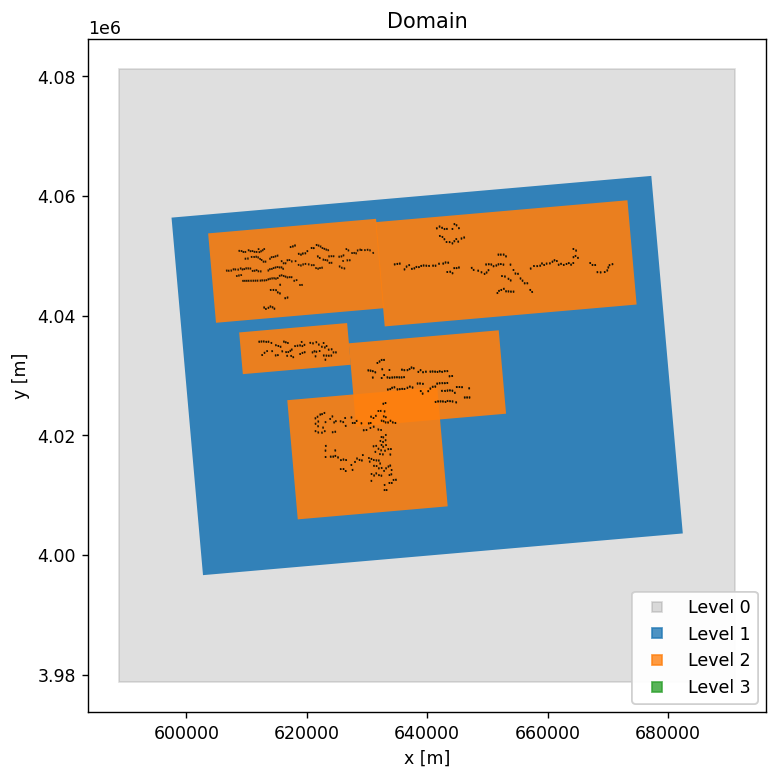

In [19]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'#'YZ' 
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)
#ax.axis('auto')
#ax.axis([620000, 621000, 4020000, 4021000])
#ax.set_xlim([620000, 621000])
#ax.set_ylim([4020000, 4021000])

ax.set_aspect('auto')
#ax.set_xlim([640000,  650000])
#ax.set_ylim([4025000, 4035000])

## Set up averaging

In [20]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()
print(case.listboxpopupwindict['listboxsampling'].getitemlist())
print(case.listboxpopupwindict['listboxpostprosetup'].getitemlist())

[]
[]


In [21]:
# Set up averaging
avgsetup = case.get_default_postprosetupdict() 
avgsetup['postprocessing_setup_name']             = 'averaging'
avgsetup['postprocessing_setup_type']             = 'TimeAveraging'
avgsetup['postprocessing_setup_averaging_window']     = 60.0
avgsetup['postprocessing_setup_averaging_start_time'] = tstart
avgsetup['postprocessing_setup_averaging_stop_time']  = 1.0E6
#case.add_populatefromdict('listboxpostprosetup', avgsetup, verbose=True)
case.add_postprosetup(avgsetup, verbose=True)

postprocessing_setup_name: 'averaging'
postprocessing_setup_type: 'TimeAveraging'
postprocessing_setup_output_frequency: 100
postprocessing_setup_fields: 'velocity'
postprocessing_setup_averaging_window: 60.0
postprocessing_setup_averaging_start_time: 16125
postprocessing_setup_averaging_stop_time: 1000000.0


In [22]:
avgobject                             = case.get_default_averagingdict()
avgobject['averaging_name']           = 'mean_average'
avgobject['averaging_averaging_type'] = 'ReAveraging'
avgobject['averaging_fields']         = 'velocity'
case.add_averaging(avgobject, verbose=True)

averaging_name: 'mean_average'
averaging_outputto: 'averaging'
averaging_averaging_type: 'ReAveraging'
averaging_fields: 'velocity'


## Add metmast sampling (skip this for radar cases)

```python
# Set up averaging
metmastpprosetup = case.get_default_postprosetupdict()
metmastpprosetup['postprocessing_setup_name'] = 'metmast_'
metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
metmastpprosetup['postprocessing_setup_output_frequency'] =  1
metmastpprosetup['postprocessing_setup_fields']           =  'velocity'
case.add_postprosetup(metmastpprosetup, verbose=True)
```

```python
site_xy   = [{'name':'H', 'long':-97.405716, 'lat':36.437261},
             {'name':'E', 'long':-97.406248, 'lat':36.379412},
             {'name':'G', 'long':-97.405855, 'lat':36.410075},
            ]
for site in site_xy:
    site['utm'] = utm.from_latlon(site['lat'], site['long'])
    
#Add Engie probe
site_xy.append({'name':'Engie1','utm':(643311, 4025472, 14, 'S' )})
```

```python
# Add metmast 
for site in site_xy:
    sampledict = case.get_default_samplingdict()
    sampledict['sampling_name']     = 'metmast_'+site['name']
    sampledict['sampling_outputto'] = 'metmast_'
    sampledict['sampling_type']     = 'LineSampler'
    sampledict['sampling_l_num_points'] = 50
    sampledict['sampling_l_start']      = [site['utm'][0], site['utm'][1], 10]
    sampledict['sampling_l_end']        = [site['utm'][0], site['utm'][1], 500]
    case.add_sampling(sampledict, verbose=False)
```

```python
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':5, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':2}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
start = time.time()
case.plotDomain(ax=ax, verbose=False)

ax.set_aspect('auto')
ax.set_xlim([625000,  650000])
ax.set_ylim([4020000, 4045000])
```

## Add sampling planes (skip this for radar cases)

In [23]:
farm_domainsize = [102400, 102400, 2560]
farm_center     = [640000, 4030000]   # In utm

```python
outputoptions="outputvars:velocity;tke;temperature;velocity_mean outputfreq:10"

samplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
hh90,  hubheight, {up}, {down}, {lateral}, 0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:90 orientation:y \
  outputto:farm_z90_ {outputoptions} 
hh153,  hubheight, {up}, {down}, {lateral}, 0,  none,  11, 11, usedx:{dx} units:meter center:specified centerx:{centerx} centery:{centery} centerz:153 orientation:y \
  outputto:farm_z153_ {outputoptions} 
""".format(centerx=farm_center[0], centery=farm_center[1], up=0.5*farm_domainsize[0], down=0.5*farm_domainsize[0], lateral=0.5*farm_domainsize[1], 
           dx=200, outputoptions=outputoptions)

samplingcsv += """
# King plains inflow/outflow
KP500, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:500 outputto:KP_z500hh_ {outputoptions}        
KP153, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:153 outputto:KP_z153ut_   {outputoptions}
KP090, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:90 outputto:KP_z090hh_   {outputoptions}
KP026, hubheight, 8500,  8500, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:26 outputto:KP_z026lt_   {outputoptions}
KP_ioflow1,  rotorplane, 8500,   8500, 12500,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:100 outputto:KP_inflow1_ noffsets:4 {outputoptions}
KP_sideplane1, streamwise, 8500, 8500, 12500,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:100 outputto:KP_sideplane1_ noffsets:2 {outputoptions}
KP_sideplane2, streamwise, 8500, 8500, -12500,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:640000 centery:4030000 centerz:100 outputto:KP_sideplane2_ noffsets:2 {outputoptions}

# AF planes
AF130, hubheight, 11000, 9000, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:130 outputto:AF_z130ut_ {outputoptions}
AF080, hubheight, 11000, 9000, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:80 outputto:AF_z080hh_ {outputoptions}
AF030, hubheight, 11000, 9000, 12500,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:30 outputto:AF_z030lt_ {outputoptions}
AF_ioflow,     rotorplane, 11000, 9000, 12500,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:100 outputto:AF_ioflow_ noffsets:1 {outputoptions}
AF_sideplane1, streamwise, 11000, 9000, 12500,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:100 outputto:AF_sideplane1_ noffsets:1 {outputoptions}
AF_sideplane2, streamwise, 11000, 9000, -12500,  100, 400, 0, 0,   usedx:20 units:meter center:specified centerx:630000 centery:4018000 centerz:100 outputto:AF_sideplane2_ noffsets:1 {outputoptions}

# TR planes
TR148, hubheight, 10000, 7500, 21000, 0,  none,  11, 11,           usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:148 outputto:TR_z148ut_ {outputoptions}
TR090, hubheight, 10000, 7500, 21000, 0,  none,  11, 11,           usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:90 outputto:TR_z090hh_ {outputoptions}
TR032, hubheight, 10000, 7500, 21000, 0,  none,  11, 11,           usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:32 outputto:TR_z032lt_ {outputoptions}
TR_ioflow,     rotorplane, 10000, 7500, 21000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:100 outputto:TR_ioflow_ noffsets:1 {outputoptions}
TR_sideplane1, streamwise, 10000, 7500, 21000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:100 outputto:TR_sideplane1_ noffsets:1 {outputoptions}
TR_sideplane2, streamwise, 10000, 7500, -21000, 100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:653000 centery:4050000 centerz:100 outputto:TR_sideplane2_ noffsets:1 {outputoptions}

# BR planes
BR132, hubheight, 4000,  3000, 9000,   0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:132 outputto:BR_z132ut_ {outputoptions}
BR080, hubheight, 4000,  3000, 9000,   0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:80 outputto:BR_z080hh_ {outputoptions}
BR029, hubheight, 4000,  3000, 9000,   0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:29 outputto:BR_z029lt_ {outputoptions}
BR_ioflow,     rotorplane, 4000,  3000, 9000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:100 outputto:BR_ioflow_ noffsets:1 {outputoptions}
BR_sideplane1, streamwise, 4000,  3000, 9000,  100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:100 outputto:BR_sideplane1_ noffsets:1 {outputoptions}
BR_sideplane2, streamwise, 4000,  3000, -9000,  100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:618000 centery:4035000 centerz:100 outputto:BR_sideplane2_ noffsets:1 {outputoptions}

# CV planes
CV121, hubheight, 10000, 5000, 14000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:121 outputto:CV_z121ut_ {outputoptions}
CV080, hubheight, 10000, 5000, 14000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:80 outputto:CV_z080hh_ {outputoptions}
CV039, hubheight, 10000, 5000, 14000,  0, none, 0, 0,              usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:39 outputto:CV_z039lt_ {outputoptions}
CV_ioflow,     rotorplane, 10000, 5000, 14000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:90 outputto:CV_ioflow_ noffsets:1 {outputoptions}
CV_sideplane1, streamwise, 10000, 5000, 14000, 100, 400, 0, 0,     usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:90 outputto:CV_sideplane1_ noffsets:1 {outputoptions}
CV_sideplane2, streamwise, 10000, 5000, -14000, 100, 400, 0, 0,    usedx:20 units:meter center:specified centerx:618000 centery:4050000 centerz:90 outputto:CV_sideplane2_ noffsets:1 {outputoptions}
""".format(outputoptions=outputoptions)
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)
```

```python
case.sampling_createAllProbes(verbose=False)
```

```python
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':6}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
start = time.time()
case.plotDomain(ax=ax, verbose=False, plotskip=50)
```

### Add some sampling just for King Plains turbines

```python
# Load the data from the database of all turbines
allturbsdf = pd.read_csv(summitcsv, low_memory=False)
allturbsdf = updateturbs(allturbsdf)
```

```python
# Get just the King Plains turbines
subset = [] 
for x in allturbsdf.iterrows():
    if x[1]['# name'].endswith('-KP'):
        subset.append(x[1])
subsetdf = pd.DataFrame(subset[:])

KP_turbinescsv = subsetdf.to_csv(index=False)
#print(subsetdf.to_csv(index=False))
```

```python
case.setAMRWindInput('turbines_csvtextbox',  KP_turbinescsv)
case.setAMRWindInput('turbines_deleteprev', True)
#case.listboxpopupwindict['listboxactuator'].deleteall()
case.turbines_createAllTurbines()
```

```python
outputoptions="outputvars:velocity;tke;temperature;velocity_mean outputfreq:10"

KPsamplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,      type, upstream, downstream, lateral, below, above, n1, n2, options
KPturbhh,  hubheight, 1020, 1020,       380,     0,     0,     11, 11, usedx:10 units:meter outputto:KPturbhh_ orientation:nacdir outputvars:velocity  {outputoptions}
KPsw,     streamwise, 1020, 1020,       0,       90,    380,   11, 11, usedx:10 units:meter outputto:KPsw_     orientation:nacdir outputvars:velocity   {outputoptions}
KProtor,  rotorplane, 1020, 1020,       250,     ,      380,   11, 11, usedx:10 units:meter outputto:KProtor_  orientation:nacdir outputvars:velocity noffsets:8  {outputoptions}
""".format(outputoptions=outputoptions)
```

```python
case.setAMRWindInput('sampling_csvtextbox', KPsamplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)
```

```python
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
#print(case.listboxpopupwindict['listboxsampling'].getitemlist())
```

```python
KPturbhh = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_KPturbhh') ]
KPsw     = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_KPsw') ]
KProtor  = [x for x in case.listboxpopupwindict['listboxsampling'].getitemlist() if x.endswith('_KProtor') ]
```

```python
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.25, 'marker':'.', 'linestyle':'None', 'mfc':'r', 'markeredgecolor':'r'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{}" #"{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':6}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KPturbhh #['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'#'YZ' 
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
start = time.time()
case.plotDomain(ax=ax, verbose=False, plotskip=5)
end = time.time()
print("Time: "+repr(end - start))

"""
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', 'mfc':'g', 'markeredgecolor':'g'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KProtor #['p_hub']
start = time.time()
case.plotDomain(ax=ax, verbose=False)
end = time.time()
print("Time: "+repr(end - start))

case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':0.1, 'marker':'.', 'linestyle':'None', 'mfc':'b', 'markeredgecolor':'b'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = KPsw #['p_hub']
start = time.time()
case.plotDomain(ax=ax, verbose=False)
end = time.time()
print("Time: "+repr(end - start))
"""
ax.set_aspect('auto')
ax.set_xlim([640000,  650000])
ax.set_ylim([4025000, 4035000])
```

## Set up the lidar probes (skip for radar cases)

```python
def convertNaluLidar(naludict, overridecenter=None, periodic=True):
    amrdict = {}
    amrdict['name'] = naludict['name'].replace('/','_')
    lidarspec       = naludict['scanning_lidar_specifications']
    
    sweep_angle           = lidarspec['sweep_angle']
    stare_time            = lidarspec['stare_time']
    step_delta_angle      = lidarspec['step_delta_angle']
    elevation_angles      = lidarspec['elevation_angles']
    T_per_ele             = stare_time*(sweep_angle/step_delta_angle)
    T_per_scan            = len(elevation_angles)*T_per_ele 
    # Get the lidar center angle
    axis                  = lidarspec['axis']
    sweep_center = np.arctan2(float(axis[1]), float(axis[0]))*180.0/np.pi  # Compute sweep_center from axis
    #print(sweep_center)
    azi1         = sweep_center - 0.5*sweep_angle
    azi2         = sweep_center + 0.5*sweep_angle
    
    amrdict['origin']     = lidarspec['center'] if overridecenter is None else overridecenter
    amrdict['length']     = lidarspec['beam_length']
    amrdict['num_points'] = naludict['points_along_line']
    amrdict['periodic']   = periodic
    t_between_azisweep    = 0.001
    
    t_table   = []
    azi_table = []
    ele_table = []
    
    if ('ground_direction') in lidarspec and lidarspec['ground_direction']==[1,0,0]:
        for dazi in elevation_angles:
            azi0    = sweep_center + dazi
            ele1    = -0.5*sweep_angle
            ele2    = +0.5*sweep_angle
            t_seg   = [0.0, T_per_ele]
            azi_seg = [azi0, azi0]
            ele_seg = [ele1, ele2]
            if len(t_table)>0:
                t0    = t_table[-1]
                t_seg = [t0+t+t_between_azisweep for t in t_seg]
            t_table = t_table + t_seg
            azi_table = azi_table + azi_seg
            ele_table = ele_table + ele_seg
    else:
        for ele in elevation_angles:
            t_seg   = [0.0, T_per_ele]
            azi_seg = [azi1, azi2]
            ele_seg = [ele, ele]
            if len(t_table)>0:
                t0    = t_table[-1]
                t_seg = [t0+t+t_between_azisweep for t in t_seg]
            t_table = t_table + t_seg
            azi_table = azi_table + azi_seg
            ele_table = ele_table + ele_seg
    
    # Convert to strings
    amrdict['time_table']      = ' '.join([repr(x) for x in t_table])
    amrdict['azimuth_table']   = ' '.join([repr(x) for x in azi_table])
    amrdict['elevation_table'] = ' '.join([repr(x) for x in ele_table])

    return amrdict

def plotLidarDict(axs, d, formatfunc=None):
    str2list = lambda l: [float(x) for x in l.split()] 
    time_table = str2list(d['time_table'])
    azimuth_table   = str2list(d['azimuth_table'])
    elevation_table = str2list(d['elevation_table'])
    axs[0].plot(time_table, azimuth_table)
    axs[1].plot(time_table, elevation_table)
    if formatfunc is not None:
        formatfunc(axs)
    return

def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf
```

### Nalu lidar definition (skip)

```python
naluyaml="""
    - name: lidar/NREL1_WakeMeandHoriz  # Wake meandering (the PPI scan of an alternating PPI/RHI scan)
      from_target_part: &allparts 1
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL1_WakeMeandVert  # Wake meandering (the RHI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]
        ground_direction: [1,0,0] # turn the sweep direction vertical

    - name: lidar/NREL1_InflowStats  # Inflow statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 40 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL1_InflowTurb  # Inflow turbulence
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP  [10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.0 #s
        sweep_angle: 30 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL1_Wake3DStats  # Wake statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8.5,-7,-5.5,-4,-2.5,-1.0,0.5,2.0,3.5,5.0,6.5,8.0,9.5]

    - name: lidar/NREL1_FarmStats_Up  #Farm statistics (upstream)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [643050.588260, 4025581.533244, 91]  # On top of 2019-WTW-7915-KP #[10050.588260, 8081.533244, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.6 #s
        sweep_angle: 120 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 7.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8,-6,-4,-2,0,2,4,6,8,10]

    - name: lidar/NREL2_InflowTurb  # Inflow turbulence
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]   # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.0 #s
        sweep_angle: 30 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL2_WakeMeandHoriz  # Wake meandering (the PPI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL2_WakeMeandVert  # Wake meandering (the RHI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]
        ground_direction: [1,0,0] # turn the sweep direction vertical

    - name: lidar/NREL2_InflowStats  # Inflow statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 40 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/NREL2_Wake3DStats  # Wake statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8.5,-7,-5.5,-4,-2.5,-1.0,0.5,2.0,3.5,5.0,6.5,8.0,9.5]

    - name: lidar/NREL2_FarmStats_Dn  # Farm statistics (downstream)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642927.453405, 4030718.728327, 91.0] # on top of 2019-WTW-4657-OE [9927.453405, 13218.728327, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.6 #s
        sweep_angle: 120 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 7.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8,-6,-4,-2,0,2,4,6,8,10]

    - name: lidar/EPFL2_InflowTurb  # Inflow turbulence
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.0 #s
        sweep_angle: 30 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/EPFL2_InflowStats  # Inflow statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP  [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 40 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/EPFL3_WakeMeandHoriz  # Wake meandering (the PPI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]

    - name: lidar/EPFL3_WakeMeandVert  # Wake meandering (the RHI scan of an alternating PPI/RHI scan)
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 0.7 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 3 #deg
        reset_time_delta: 4.9 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]
        ground_direction: [1,0,0] # turn the sweep direction vertical

    - name: lidar/EPFL3_Wake3DStats  # Wake statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [642940.656099, 4028713.362363, 91] # On top of 2019-WTW-4697-KP [9940.656099, 11213.362363, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [-0.087155742,0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.1 #s
        sweep_angle: 20 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 1.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [-10,-8.5,-7,-5.5,-4,-2.5,-1.0,0.5,2.0,3.5,5.0,6.5,8.0,9.5]

    - name: lidar/NRELG_SpeedupStats  # Speedup statistics
      from_target_part: *allparts
      type: scanning
      frequency: 10 #Hz
      points_along_line: 667
      output: text
      reuse_search_data: no            
      scanning_lidar_specifications:
        center: [644600.601753, 4027108.285963, 91.0] # On top of 2019-WTW-4713-KP [11600.601753, 9608.285963, 91.0]    # Location of the scanning LIDAR
        beam_length: 2000.0 #m
        axis: [0.087155742,-0.996194698,0] # Zero angle vector for the angular sweep; [0.087155742,-0.996194698,0] for inflow scan and [-0.087155742,0.996194698,0] for wake scan
        stare_time: 1.2 #s
        sweep_angle: 360 #deg, Extent of angular sweep between sweep_angle/2 to -sweep_angle/2
        step_delta_angle: 2.5 #deg
        reset_time_delta: 0 #s, Time to reset LIDAR after sweep. 
        elevation_angles: [0]
"""
```

```python
yamldict = Loader(naluyaml)
```

### Add to amr-wind input

```python
# Set up averaging
lidarpprosetup = case.get_default_postprosetupdict()
lidarpprosetup['postprocessing_setup_name'] = 'lidar_'
lidarpprosetup['postprocessing_setup_type'] = 'Sampling'
lidarpprosetup['postprocessing_setup_output_frequency'] =  1
lidarpprosetup['postprocessing_setup_fields']           =  'velocity'
case.add_postprosetup(lidarpprosetup, verbose=True)
```

```python
verbose = False
# Add metmast 
for lidar in yamldict:
    amrdict = convertNaluLidar(lidar)
    sampledict = case.get_default_samplingdict()
    sampledict['sampling_name']     = amrdict['name']
    del amrdict['name']
    sampledict['sampling_outputto'] = 'lidar_'
    sampledict['sampling_type']     = 'LidarSampler'
    #print(amrdict)
    for k, g in amrdict.items():
        sampledict['sampling_lidar_'+k] = g
    #sampledict['sampling_l_num_points'] = 50
    #sampledict['sampling_l_start']      = [site['utm'][0], site['utm'][1], 10]
    #sampledict['sampling_l_end']        = [site['utm'][0], site['utm'][1], 500]
    case.add_sampling(sampledict, verbose=verbose)
    if verbose: print('=================')
```

## Add probes from Alex (skip for radar)

```
# From Alex Rybchuk's email:
# ---------------------------
incflo.post_processing         = KP_east
KP_east.type                   = Sampling
KP_east.output_frequency       = 10
KP_east.fields                 = velocity temperature tke velocity_mean
KP_east.labels                 = streamwise xz-plane yz-plane

KP_east.streamwise.type        = PlaneSampler
KP_east.streamwise.num_points  = 1542 51
KP_east.streamwise.origin      = 643401.36 4020514.12 0.0
KP_east.streamwise.axis1       = -1343.83 15360.00 0.0
KP_east.streamwise.axis2       = 0.0 0.0 500.0
KP_east.streamwise.normal      = 1.0 0.0 0.0
KP_east.streamwise.offsets     = -4000.0 4000.0

KP_east.xz-plane.type          = PlaneSampler
KP_east.xz-plane.num_points    = 1537 51
KP_east.xz-plane.origin        = 642729.44 4020514.12 0.0
KP_east.xz-plane.axis1         = 0.00 15360.00 0.0
KP_east.xz-plane.axis2         = 0.0 0.0 500.0
KP_east.xz-plane.normal        = 1.0 0.0 0.0
KP_east.xz-plane.offsets       = -4000.0 4000.0

KP_east.yz-plane.type          = PlaneSampler
KP_east.yz-plane.num_points    = 1537 51
KP_east.yz-plane.origin        = 635049.44 4025269.30 0.0
KP_east.yz-plane.axis1         = 15360.00 0.00 0.0
KP_east.yz-plane.axis2         = 0.0 0.0 500.0
KP_east.yz-plane.normal        = 0.0 1.0 0.0
KP_east.yz-plane.offsets       = 1800.0 3050.0 5050.0
```

```python
# Set up averaging
pprosetup = case.get_default_postprosetupdict()
pprosetup['postprocessing_setup_name'] = 'KP_east_'
pprosetup['postprocessing_setup_type'] = 'Sampling'
pprosetup['postprocessing_setup_output_frequency'] =  10
pprosetup['postprocessing_setup_fields']           =  'velocity temperature tke velocity_mean'.split()
case.add_postprosetup(pprosetup, verbose=True)
```

```python
sampledict = case.get_default_samplingdict()
sampledict['sampling_name']     = 'streamwise'
sampledict['sampling_outputto'] = 'KP_east_'
sampledict['sampling_type']     = 'PlaneSampler'
sampledict['sampling_p_num_points'] = [1542, 51]
sampledict['sampling_p_origin']     = [643401.36, 4020514.12, 0.0]
sampledict['sampling_p_axis1']      = [-1343.83, 15360.00, 0.0]
sampledict['sampling_p_axis2']      = [0.0, 0.0, 500.0]
sampledict['sampling_p_normal']      = [1.0, 0.0, 0.0]
sampledict['sampling_p_offsets']      = '-4000.0 4000.0'
case.add_sampling(sampledict, verbose=verbose)

sampledict = case.get_default_samplingdict()
sampledict['sampling_name']     = 'xz-plane'
sampledict['sampling_outputto'] = 'KP_east_'
sampledict['sampling_type']     = 'PlaneSampler'
sampledict['sampling_p_num_points'] = [1537, 51]
sampledict['sampling_p_origin']     = [642729.44, 4020514.12, 0.0]
sampledict['sampling_p_axis1']      = [0.00, 15360.00, 0.0]
sampledict['sampling_p_axis2']      = [0.0, 0.0, 500.0]
sampledict['sampling_p_normal']      = [1.0, 0.0, 0.0]
sampledict['sampling_p_offsets']      = '-4000.0 4000.0'
case.add_sampling(sampledict, verbose=verbose)

sampledict = case.get_default_samplingdict()
sampledict['sampling_name']     = 'yz-plane'
sampledict['sampling_outputto'] = 'KP_east_'
sampledict['sampling_type']     = 'PlaneSampler'
sampledict['sampling_p_num_points'] = [1537, 51]
sampledict['sampling_p_origin']     = [635049.44, 4025269.30, 0.0]
sampledict['sampling_p_axis1']      = [15360.00, 0.00, 0.0]
sampledict['sampling_p_axis2']      = [0.0, 0.0, 500.0]
sampledict['sampling_p_normal']      = [0.0, 1.0, 0.0]
sampledict['sampling_p_offsets']      = '1800.0 3050.0 5050.0'
case.add_sampling(sampledict, verbose=verbose)
```

## Add radar sampling

### For reference: Nalu Wind inputs

From Ken's email, these are the radar inputs:
```
- name: radar/radar1
  type: radar
  frequency: 85 # SET TO 1/dt_Nalu   (azimuthal oversampling of 0.352 deg divided by scan speed of 30 deg/s equals 0.0117333 s or 85.22 Hz)
  points_along_line: 2083  # SET TO (gridWidth^2+gridLength^2)^0.5/7.5 m
  output: text            
  reuse_search_data: no            
  radar_cone_filter:
    cone_angle: 0.25 #half angle of cone, in degrees
    quadrature_type: truncated_normal_halfpower
    lines_per_cone_circle: 15 # number of lines around the cone circle
  radar_specifications:
    bbox: [6000., 4500., 0., 16000., 16500., 2500.] # unstable, SET TO GRID DIMENSTIONS (where to cut the radar line(m), [x1,y1,z1,x2,y2,z2])
    center: [-18654.500942, 11260.269009, 102.6] # SET TO LOCATION OF TTU RADAR RELATIVE TO DOMAIN ORIGIN (ideally outside of the box) (see AWAKEN-turbines-ele_kab.xlsx)
    beam_length: 35000  # m of beam length
    angular_speed: 30 #degrees to sweep in a second
    axis: [0.9659, 0.2588, 0] # scan sector of 5-145 deg gives centerline of 75 deg or [sind(75) cosd(75) 0] (main axis, cone grid is set around this)
    sweep_angle: 145 #angle of the sweep
    reset_time_delta:  1 # time to pause after a sweep of an elevation angle
    elevation_angles: [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5] # elevation angles to scan after reset

- name: radar/radar2
  type: radar
  frequency: 85 # SET TO 1/dt_Nalu   (azimuthal oversampling of 0.352 deg divided by scan speed of 30 deg/s equals 0.0117333 s or 85.22 Hz)
  points_along_line: 2083  # SET TO (gridWidth^2+gridLength^2)^0.5/7.5 m
  output: text
  reuse_search_data: no            
  radar_cone_filter:
    cone_angle: 0.25 #half angle of cone, in degrees
    quadrature_type: truncated_normal_halfpower
    lines_per_cone_circle: 15 # number of lines around the cone circle
  radar_specifications:
    bbox: [6000., 4500., 0., 16000., 16500., 2500.] # unstable, SET TO GRID DIMENSTIONS (where to cut the radar line(m), [x1,y1,z1,x2,y2,z2])
    center: [-13713.865281,941.913201, 78.4] # SET TO LOCATION OF TTU RADAR RELATIVE TO DOMAIN ORIGIN (ideally outside of the box) (see AWAKEN-turbines-ele_kab.xlsx)
    beam_length: 35000  # m of beam length
    angular_speed: 30 #degrees to sweep in a second
    axis: [0.8192, 0.5736, 0] # scan sector of 345-125 deg gives centerline of 55 deg or [sind(55) cosd(55) 0] (main axis, cone grid is set around this)
    sweep_angle: 145 #angle of the sweep
    reset_time_delta:  1 # time to pause after a sweep of an elevation angle
    elevation_angles: [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5] # elevation angles to scan after reset

    - name: radar_focused/radar1
      type: radar
      frequency: 85 # SET TO 1/dt_Nalu   (azimuthal oversampling of 0.352 deg divided by scan speed of 30 deg/s equals 0.0117333 s or 85.22 Hz)
      points_along_line: 2083  # SET TO (gridWidth^2+gridLength^2)^0.5/7.5 m
      output: text            
      reuse_search_data: no            
      radar_cone_filter:
        cone_angle: 0.25 #half angle of cone, in degrees
        quadrature_type: truncated_normal_halfpower
        lines_per_cone_circle: 15 # number of lines around the cone circle
      radar_specifications:
        bbox: [6000., 4500., 0., 16000., 16500., 2500.] # unstable, SET TO GRID DIMENSTIONS (where to cut the radar line(m), [x1,y1,z1,x2,y2,z2])
        center: [-18654.500942, 11260.269009, 102.6] # SET TO LOCATION OF TTU RADAR RELATIVE TO DOMAIN ORIGIN (ideally outside of the box) (see AWAKEN-turbines-ele_kab.xlsx)
        beam_length: 35000  # m of beam length
        angular_speed: 30 #degrees to sweep in a second
        axis: [0.9945, -0.1045, 0] # scan sector of 5-145 deg gives centerline of 96 deg or [sind(96) cosd(96) 0] (main axis, cone grid is set around this)
        sweep_angle: 70 #angle of the sweep
        reset_time_delta:  1 # time to pause after a sweep of an elevation angle
        elevation_angles: [-0.1, 0.0, 0.1, 0.2] # elevation angles to scan after reset

    - name: radar_focused/radar2
      type: radar
      frequency: 85 # SET TO 1/dt_Nalu   (azimuthal oversampling of 0.352 deg divided by scan speed of 30 deg/s equals 0.0117333 s or 85.22 Hz)
      points_along_line: 2083  # SET TO (gridWidth^2+gridLength^2)^0.5/7.5 m
      output: text
      reuse_search_data: no            
      radar_cone_filter:
        cone_angle: 0.25 #half angle of cone, in degrees
        quadrature_type: truncated_normal_halfpower
        lines_per_cone_circle: 15 # number of lines around the cone circle
      radar_specifications:
        bbox: [6000., 4500., 0., 16000., 16500., 2500.] # unstable, SET TO GRID DIMENSTIONS (where to cut the radar line(m), [x1,y1,z1,x2,y2,z2])
        center: [-13713.865281,941.913201, 78.4] # SET TO LOCATION OF TTU RADAR RELATIVE TO DOMAIN ORIGIN (ideally outside of the box) (see AWAKEN-turbines-ele_kab.xlsx)
        beam_length: 35000  # m of beam length
        angular_speed: 30 #degrees to sweep in a second
        axis: [0.9563, 0.2924, 0] # scan sector of 345-125 deg gives centerline of 73 deg or [sind(73) cosd(73) 0] (main axis, cone grid is set around this)
        sweep_angle: 70 #angle of the sweep
        reset_time_delta:  1 # time to pause after a sweep of an elevation angle
        elevation_angles: [-0.1, 0.0, 0.1, 0.2] # elevation angles to scan after reset

```

In [24]:
# Calculate the turbine origins (in real domain)
radar1origin_nalu = [-18654.500942, 11260.269009, 102.6]
radar2origin_nalu = [-13713.865281,941.913201, 78.4]

domaincorner      = [610000, 4017500, 0.0]
turbineoffset     = [ 23000, 0, 0.0]

In [25]:
radar1origin_amr = np.array(radar1origin_nalu) + np.array(domaincorner) + np.array(turbineoffset)
radar2origin_amr = np.array(radar2origin_nalu) + np.array(domaincorner) + np.array(turbineoffset)

print(radar1origin_amr)
print(radar2origin_amr)

[6.14345499e+05 4.02876027e+06 1.02600000e+02]
[6.19286135e+05 4.01844191e+06 7.84000000e+01]


In [26]:
# test plot the radar locations
metmastpprosetup = case.get_default_postprosetupdict()
metmastpprosetup['postprocessing_setup_name'] = 'metmast_'
metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
metmastpprosetup['postprocessing_setup_output_frequency'] =  1
metmastpprosetup['postprocessing_setup_fields']           =  'velocity'
case.add_postprosetup(metmastpprosetup, verbose=True)

sampledict = case.get_default_samplingdict()
sampledict['sampling_name']     = 'metmast_radar1'
sampledict['sampling_outputto'] = 'metmast_'
sampledict['sampling_type']     = 'LineSampler'
sampledict['sampling_l_num_points'] = 50
sampledict['sampling_l_start']      = radar1origin_amr
sampledict['sampling_l_end']        = radar1origin_amr + np.array([0, 0, 100])
case.add_sampling(sampledict, verbose=False)

sampledict = case.get_default_samplingdict()
sampledict['sampling_name']     = 'metmast_radar2'
sampledict['sampling_outputto'] = 'metmast_'
sampledict['sampling_type']     = 'LineSampler'
sampledict['sampling_l_num_points'] = 50
sampledict['sampling_l_start']      = radar2origin_amr
sampledict['sampling_l_end']        = radar2origin_amr + np.array([0, 0, 100])
case.add_sampling(sampledict, verbose=False)


postprocessing_setup_name: 'metmast_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: 'velocity'
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


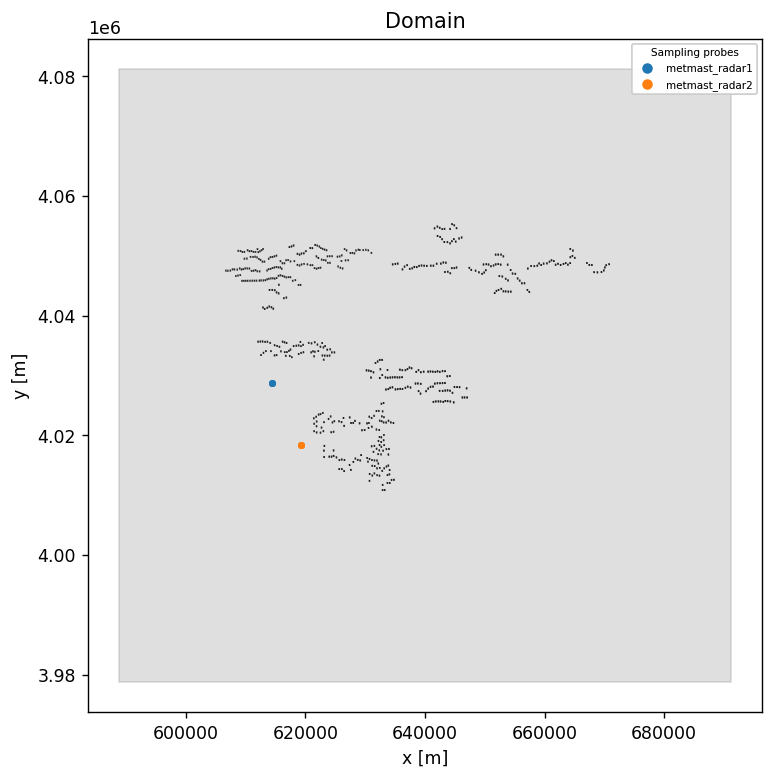

In [27]:
# Plot the domain
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes_style']  = "{'markersize':5, 'marker':'.', 'linestyle':'None', }"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':2}"
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['metmast_radar1', 'metmast_radar2'] 
#case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] 
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
start = time.time()
case.plotDomain(ax=ax, verbose=False)

### Equivalent AMR-Wind setup
See https://cee-gitlab.sandia.gov/-/snippets/701 for snippet of how to set up radar in the amrwind-frontend

In [28]:
 # Set up the postprocessing for radar
radarpprosetup = case.get_default_postprosetupdict()
radarpprosetup['postprocessing_setup_name'] = 'radaroutput_'        # This is the prefix that will go in front of all output files
radarpprosetup['postprocessing_setup_type'] = 'Sampling'
radarpprosetup['postprocessing_setup_output_frequency'] =  1           # QUESTION FOR NATE: SHOULD THIS ALWAYS BE 1?
radarpprosetup['postprocessing_setup_fields']           =  'velocity'  # QUESTION FOR NATE: Do we need to define this?
case.add_postprosetup(radarpprosetup, verbose=True)

postprocessing_setup_name: 'radaroutput_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: 'velocity'
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [29]:
# Add the radar entry
radar1dict = case.get_default_samplingdict()
radar1dict['sampling_name']     = 'radar1'          # Whatever name you want to call the radar
radar1dict['sampling_outputto'] = 'radaroutput_'          # Send it to the file defined in postprocessing_setup_name above
radar1dict['sampling_type']     = 'RadarSampler'    # Make it a radar sampler

prefix = 'sampling_radar_'
radar1dict[prefix+'num_points']                = 2083
radar1dict[prefix+'origin']                    = radar1origin_amr
radar1dict[prefix+'sampling_frequency']        = 85.0
radar1dict[prefix+'device_sampling_frequency'] = 30.0
radar1dict[prefix+'radar_cone_angle']   = 0.25
radar1dict[prefix+'radar_quadrature_type'] = 'truncated_normal_halfpower'
radar1dict[prefix+'radar_npts_azimuth'] = 15   # Same as lines_per_cone_circle?
radar1dict[prefix+'radar_beam_length']  = 35000  
radar1dict[prefix+'angular_speed']      = 30.0
radar1dict[prefix+'sweep_angle']        = 145.0
radar1dict[prefix+'reset_time']         = 1.0
radar1dict[prefix+'elevation_angles']   = '0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5'
radar1dict[prefix+'axis']               = [0.9659, 0.2588, 0]  
radar1dict[prefix+'vertical_unit_dir']  = [0.0, 0.0, 1.0]

case.add_sampling(radar1dict, verbose=False)

In [30]:
# Add the radar entry
radar2dict = case.get_default_samplingdict()
radar2dict['sampling_name']     = 'radar2'          # Whatever name you want to call the radar
radar2dict['sampling_outputto'] = 'radaroutput_'          # Send it to the file defined in postprocessing_setup_name above
radar2dict['sampling_type']     = 'RadarSampler'    # Make it a radar sampler

prefix = 'sampling_radar_'
radar2dict[prefix+'num_points']                = 2083
radar2dict[prefix+'origin']                    = radar2origin_amr
radar2dict[prefix+'sampling_frequency']        = 85.0
radar2dict[prefix+'device_sampling_frequency'] = 30.0
radar2dict[prefix+'radar_cone_angle']   = 0.25
radar2dict[prefix+'radar_quadrature_type'] = 'truncated_normal_halfpower'
radar2dict[prefix+'radar_npts_azimuth'] = 15   # Same as lines_per_cone_circle?
radar2dict[prefix+'radar_beam_length']  = 35000  
radar2dict[prefix+'angular_speed']      = 30.0
radar2dict[prefix+'sweep_angle']        = 145.0
radar2dict[prefix+'reset_time']         = 1.0
radar2dict[prefix+'elevation_angles']   = '0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3 1.4 1.5'
radar2dict[prefix+'axis']               = [0.8192, 0.5736, 0] 
radar2dict[prefix+'vertical_unit_dir']  = [0.0, 0.0, 1.0]

case.add_sampling(radar2dict, verbose=False)

In [31]:
# Add the radar entry
radar1dict = case.get_default_samplingdict()
radar1dict['sampling_name']     = 'radar1focused'          # Whatever name you want to call the radar
radar1dict['sampling_outputto'] = 'radaroutput_'          # Send it to the file defined in postprocessing_setup_name above
radar1dict['sampling_type']     = 'RadarSampler'    # Make it a radar sampler

prefix = 'sampling_radar_'
radar1dict[prefix+'num_points']                = 2083
radar1dict[prefix+'origin']                    = radar1origin_amr
radar1dict[prefix+'sampling_frequency']        = 85.0
radar1dict[prefix+'device_sampling_frequency'] = 30.0
radar1dict[prefix+'radar_cone_angle']   = 0.25
radar1dict[prefix+'radar_quadrature_type'] = 'truncated_normal_halfpower'
radar1dict[prefix+'radar_npts_azimuth'] = 15   # Same as lines_per_cone_circle?
radar1dict[prefix+'radar_beam_length']  = 35000  
radar1dict[prefix+'angular_speed']      = 30.0
radar1dict[prefix+'sweep_angle']        = 70.0
radar1dict[prefix+'reset_time']         = 1.0
radar1dict[prefix+'elevation_angles']   = '-0.1 0.0 0.1 0.2' 
radar1dict[prefix+'axis']               = [0.9945, -0.1045, 0]   
radar1dict[prefix+'vertical_unit_dir']  = [0.0, 0.0, 1.0]

case.add_sampling(radar1dict, verbose=False)

In [32]:
# Add the radar entry
radar2dict = case.get_default_samplingdict()
radar2dict['sampling_name']     = 'radar2focused'          # Whatever name you want to call the radar
radar2dict['sampling_outputto'] = 'radaroutput_'          # Send it to the file defined in postprocessing_setup_name above
radar2dict['sampling_type']     = 'RadarSampler'    # Make it a radar sampler

prefix = 'sampling_radar_'
radar2dict[prefix+'num_points']                = 2083
radar2dict[prefix+'origin']                    = radar2origin_amr
radar2dict[prefix+'sampling_frequency']        = 85.0
radar2dict[prefix+'device_sampling_frequency'] = 30.0
radar2dict[prefix+'radar_cone_angle']   = 0.25
radar2dict[prefix+'radar_quadrature_type'] = 'truncated_normal_halfpower'
radar2dict[prefix+'radar_npts_azimuth'] = 15   # Same as lines_per_cone_circle?
radar2dict[prefix+'radar_beam_length']  = 35000  
radar2dict[prefix+'angular_speed']      = 30.0
radar2dict[prefix+'sweep_angle']        = 70.0
radar2dict[prefix+'reset_time']         = 1.0
radar2dict[prefix+'elevation_angles']   = '-0.1 0.0 0.1 0.2'
radar2dict[prefix+'axis']               = [0.9563, 0.2924, 0] 
radar2dict[prefix+'vertical_unit_dir']  = [0.0, 0.0, 1.0]

case.add_sampling(radar2dict, verbose=False)

## Print the input file

### Set up the turbine case

In [33]:
os.chdir(cwd)

# remove all of the existing turbines, and add them back (with OpenFAST/ADM)
removeturbines(case)
allturbsdf = pd.read_csv(summitcsv, low_memory=False)
allturbsdf = updateturbs(allturbsdf, changeKPturb='Summit_GE2.8-127_ADM')
turbinescsvstring = allturbsdf.to_csv(index=False)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsvstring)
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

# Go to the run directory
if not os.path.exists(farmrundir):
    os.makedirs(farmrundir)
os.chdir(farmrundir)

# Create all of the turbines
case.turbines_createAllTurbines()

# Write the input file
inputfile=case.writeAMRWindInput(outputfile)
if verbose: print(inputfile)

# Make a copy of the file
shutil.copy2(outputfile, cwd)
os.chdir(cwd)

SET incflo.physics: ['ABL']
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4713-KP_OpenFAST3p3_NREL2p8-127.bugfix
copy /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix failed
2019-WTW-4713-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4655-KP_OpenFAST3p3_NREL2p8-127.bugfix
copy /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix failed
2019-WTW-4655-KP_OpenFAST3p3_NREL2p8-127.bugfix/NREL-2p8-127.fst
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix to 2019-WTW-4651-KP_OpenFAST3p3_NREL2p8-127.bugfix
copy /autofs/nccs-svm1_proj/cfd162/lcheung/AWAKEN_summit_setup/turbines/OpenFAST3p3_NREL2p8-127.bugfix failed
2019-WTW

### Set up the no-turbine case

In [34]:
os.chdir(cwd)
removeturbines(case)
inputfile=case.writeAMRWindInput(noturboutputfile)
if verbose: print(inputfile)

SET incflo.physics: ['ABL']
